In [1]:
from li2021_odeint import change_params, create_fig3, lightsim_20min_5min, params
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mxlpy import Simulator, make_protocol
from mxlpy_version import get_li2021
from tqdm import tqdm
import numpy as np
import mxlbricks.names as n

## Figure 3

In [50]:
light_100 = make_protocol([(20 * 60, {"PAR": 100}), (5 * 60, {"PAR": 0})])
light_500 = make_protocol([(20 * 60, {"PAR": 500}), (5 * 60, {"PAR": 0})])

g_types = ["WT", "clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"]

res_mine = {}
for g_type in (pbar := tqdm(g_types)):
    pbar.set_description(f"Simulating '{g_type}' in mxlpy")
    m = get_li2021()
    
    if "clce2" in g_type:
        m.update_parameter("k_CLCE", 0)
    if "vccn1" in g_type:
        m.update_parameter("k_VCCN1", 0)
    if "kea3" in g_type:
        m.update_parameter("k_KEA", 0)
    
    res_mine[g_type] = {}
    
    for par, prtc in zip(["100", "500"], [light_100, light_500]):
        s = Simulator(m)
        s.simulate_protocol(prtc, time_points_per_step=1000)
        variables, fluxes = s.get_result()
        res_mine[g_type][par] = variables

Simulating 'vccn1clce2kea3' in mxlpy: 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


In [3]:
from deltapsi_leaf_old import sim_a_gtype

res_old = {
    "WT": {"100": {}, "500": {}},
    "clce2": {"100": {}, "500": {}},
    "vccn1": {"100": {}, "500": {}},
    "kea3": {"100": {}, "500": {}},
    "clce2vccn1": {"100": {}, "500": {}},
    "clce2kea3": {"100": {}, "500": {}},
    "vccn1kea3": {"100": {}, "500": {}},
    "vccn1clce2kea3": {"100": {}, "500": {}},
}

res_old["WT"]["100"] = sim_a_gtype(res_old["WT"]["100"], 'WT', 100);
res_old["WT"]["500"] = sim_a_gtype(res_old["WT"]["500"], 'WT', 500);
res_old["clce2"]["100"] = sim_a_gtype(res_old["clce2"]["100"], 'clce2', 100);
res_old["clce2"]["500"] = sim_a_gtype(res_old["clce2"]["500"], 'clce2', 500);
res_old["vccn1"]["100"] = sim_a_gtype(res_old["vccn1"]["100"], 'vccn1', 100);
res_old["vccn1"]["500"] = sim_a_gtype(res_old["vccn1"]["500"], 'vccn1', 500);
res_old["kea3"]["100"] = sim_a_gtype(res_old["kea3"]["100"], 'kea3', 100);
res_old["kea3"]["500"] = sim_a_gtype(res_old["kea3"]["500"], 'kea3', 500);
res_old["clce2vccn1"]["100"] = sim_a_gtype(res_old["clce2vccn1"]["100"], 'clce2vccn1', 100);
res_old["clce2vccn1"]["500"] = sim_a_gtype(res_old["clce2vccn1"]["500"], 'clce2vccn1', 500);
res_old["clce2kea3"]["100"] = sim_a_gtype(res_old["clce2kea3"]["100"], 'clce2kea3', 100);
res_old["clce2kea3"]["500"] = sim_a_gtype(res_old["clce2kea3"]["500"], 'clce2kea3', 500);
res_old["vccn1kea3"]["100"] = sim_a_gtype(res_old["vccn1kea3"]["100"], 'vccn1kea3', 100);
res_old["vccn1kea3"]["500"] = sim_a_gtype(res_old["vccn1kea3"]["500"], 'vccn1kea3', 500);
res_old["vccn1clce2kea3"]["100"] = sim_a_gtype(res_old["vccn1clce2kea3"]["100"], 'vccn1clce2kea3', 100);
res_old["vccn1clce2kea3"]["500"] = sim_a_gtype(res_old["vccn1clce2kea3"]["500"], 'vccn1clce2kea3', 500);

FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,17.142857142857142


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,40.0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,17.142857142857142
k_CLCE,800000,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,40.0
k_CLCE,800000,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,17.142857142857142
k_VCCN1,12,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,40.0
k_VCCN1,12,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,17.142857142857142
k_KEA,2500000,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,40.0
k_KEA,2500000,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,17.142857142857142
k_VCCN1,12,0
k_CLCE,800000,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,40.0
k_VCCN1,12,0
k_CLCE,800000,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,17.142857142857142
k_KEA,2500000,0
k_CLCE,800000,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,40.0
k_KEA,2500000,0
k_CLCE,800000,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,17.142857142857142
k_KEA,2500000,0
k_VCCN1,12,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,40.0
k_KEA,2500000,0
k_VCCN1,12,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,17.142857142857142
k_KEA,2500000,0
k_VCCN1,12,0
k_CLCE,800000,0


FloatProgress(value=0.0, max=101.0)

Change Constants


Changed Parameter,Old Value,New Value
k_CBC,60,40.0
k_KEA,2500000,0
k_VCCN1,12,0
k_CLCE,800000,0


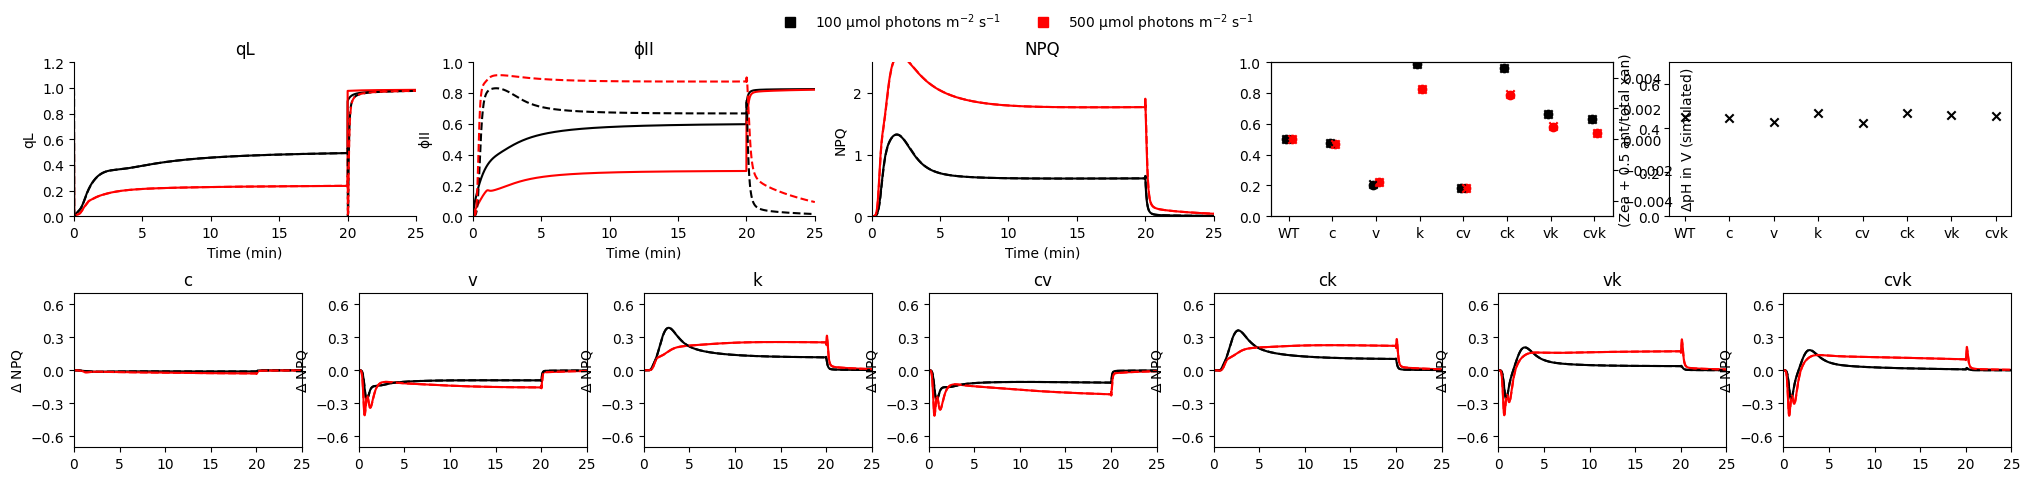

In [28]:
fig3, axs = plt.subplot_mosaic([
        ["A"] * 7 + ["B"] * 7 + ["C"] * 7 + ["D"] * 7 + ["E"] * 7,
        ["F"] * 5 + ["G"] * 5 + ["H"] * 5 + ["I"] * 5 + ["J"] * 5 + ["K"] * 5 + ["L"] * 5
    ], figsize=(25,5))

for res, color in zip([res_mine["WT"]["100"], res_mine["WT"]["500"]], ["black", "red"]): # Plot qL, Phi2, NPQ for WT
    axs["A"].plot(res.index / 60, 1-res["QA_red"], color=color)
    axs["B"].plot(res.index / 60, res["Phi2"], color=color)
    axs["C"].plot(res.index / 60, res["NPQ"], color=color)
    
axs["A"].set_ylim(0, 1.2)
axs["A"].set_yticks(np.arange(0, 1.4, 0.2))
axs["A"].set_ylabel("qL")
axs["A"].set_title("qL")

axs["B"].set_ylim(0, 1.0)
axs["B"].set_ylabel(r"$\mathrm{\phi}$II")
axs["B"].set_title(r"$\mathrm{\phi}$II")

axs["C"].set_ylim(0, 2.5)
axs["C"].set_yticks(np.arange(0, 3, 1))
axs["C"].set_ylabel("NPQ")
axs["C"].set_title("NPQ")

for ax_let, key in zip(list("FGHIJKL"), ["clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"]): # Plot NPQ for mutations
    ax = axs[ax_let]
    for par, color in zip(["100", "500"], ["black", "red"]):
        res = res_mine[key][par]
        ax.plot(res.index / 60, res["NPQ"] - res_mine["WT"][par]["NPQ"], color = color)
        
x_coord = 0
width = 0.125
xcoords = []
xcoords_labels = []
ax_D_right = axs["D"].twinx()

for key in ["WT", "clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"]:
    
    ax_D_right.scatter(x_coord - width, max(res_mine[key]["100"]["delta_pH_inVolts"]) - max(res_mine["WT"]["100"]["delta_pH_inVolts"]), color="black", marker="o")
    ax_D_right.scatter(x_coord + width, max(res_mine[key]["500"]["delta_pH_inVolts"]) - max(res_mine["WT"]["500"]["delta_pH_inVolts"]), color="red", marker="o")
    
    label = ""
    if key == "WT":
        label = "WT"
    if "clce2" in key:
        label += "c"
    if "vccn1" in key:
        label += "v"
    if "kea3" in key:
        label += "k"
    xcoords_labels.append(label)

    max_Z = max(res_mine[key]["500"][n.zx()])
    max_V = max(res_mine[key]["500"][n.vx()])
    axs["E"].scatter(x_coord, max_Z / (max_Z + max_V), color="black", marker="x")
    xcoords += [x_coord]
    x_coord += 2

for ax in [axs["D"], axs["E"]]:
    ax.set_xticks(xcoords, xcoords_labels)
    
ax_D_right.set_ylabel(r"$\Delta \mathrm{pH}$ in V (simulated)")
ax_D_right.set_ylim(-0.005, 0.005)
axs["E"].set_ylabel(r"(Zea + 0.5 ant/total xan)")
axs["E"].set_ylim(0, 0.7)
    
fig3.legend(
    [
        Line2D([0], [0], color="black", marker="s", markersize=7, ls="None"),
        Line2D([0], [0], color="red", marker="s", markersize=7, ls="None"),
    ],
    ["100 µmol photons m$^{-2}$ s$^{-1}$", "500 µmol photons m$^{-2}$ s$^{-1}$"],
    ncols=2,
    frameon=False,
    loc="upper center",
)

plt.subplots_adjust(hspace=0.5, wspace=500)
plt.tight_layout()

for ax in [axs["A"], axs["B"], axs["C"]]:
    ax.set_xlim(0, 25)
    ax.set_xlabel("Time (min)")
    ax.spines[["right", "top"]].set_visible(False)



for ax_let, key in zip(
    list("FGHIJKL"),
    [
        "clce2",
        "vccn1",
        "kea3",
        "clce2vccn1",
        "clce2kea3",
        "vccn1kea3",
        "vccn1clce2kea3",
    ],
):
    ax = axs[ax_let]

    ax.set_ylim(-0.7, 0.7)
    ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
    ax.set_ylabel(r"$\Delta$ NPQ")
    ax.set_xlim(0, 25)
    ax.set_xticks([0, 5, 10, 15, 20, 25])

    title = ""
    if "clce2" in key:
        title += "c"
    if "vccn1" in key:
        title += "v"
    if "kea3" in key:
        title += "k"
    ax.set_title(title)
    
for res, color in zip([res_old["WT"]["100"], res_old["WT"]["500"]], ["black", "red"]):
    axs["A"].plot(res["time_axis_min"], 1-res["QAm"], color=color, ls="dashed")
    axs["B"].plot(res["time_axis_min"], res["Phi2"], color=color, ls="dashed")
    axs["C"].plot(res["time_axis_min"], res["NPQ_array"], color=color, ls="dashed")
    
for ax_let, key in zip(list("FGHIJKL"), ["clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"]):
    ax = axs[ax_let]
    for par, color in zip(["100", "500"], ["black", "red"]):
        res = res_old[key][par]
        ax.plot(res["time_axis_min"], res["NPQ_array"] - res_old["WT"][par]["NPQ_array"], color = color, ls="dashed")

x_coord = 0
width = 0.125
xcoords = []
for key in ["WT", "clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"]:
    ax_D_right.scatter(x_coord - width, max(res_old[key]["100"]["delta_pH_V"]) - max(res_old["WT"]["100"]["delta_pH_V"]), color="black", marker="x")
    ax_D_right.scatter(x_coord + width, max(res_old[key]["500"]["delta_pH_V"]) - max(res_old["WT"]["500"]["delta_pH_V"]), color="red", marker="x")
    
    xcoords += [x_coord]
    x_coord += 2

plt.show()

In [29]:
get_li2021().get_stoichiometries_of_variable(n.pottassium("_lumen"))

{'v_KEA': 0.000587, 'v_K_channel': -0.000587}

In [31]:
get_li2021().get_fluxes()

v_PSII_recombination         0.000000e+00
v_PSII_charge_separations    2.489786e+01
v_PQ_reduction_QA            0.000000e+00
v_PQH2_oxidation_QA          0.000000e+00
v_b6f                       -1.864368e-03
v_NDH                        0.000000e+00
v_PGR                        0.000000e+00
v_PSI_charge_separation      2.001000e+01
v_PC_oxidation_P700          0.000000e+00
v_LEF                        0.000000e+00
v_Mehler                     0.000000e+00
v_CBB_NADPH                 -0.000000e+00
v_KEA                        0.000000e+00
v_K_channel                  0.000000e+00
v_VCCN1                      0.000000e+00
v_CLCE                       0.000000e+00
v_leak                       0.000000e+00
v_pmf_protons_activity       9.943902e-02
v_ZE                         0.000000e+00
violaxanthin_deepoxidase     2.009509e-10
dtype: float64

Simulating 'vccn1clce2kea3': 100%|██████████| 8/8 [00:01<00:00,  6.75it/s]


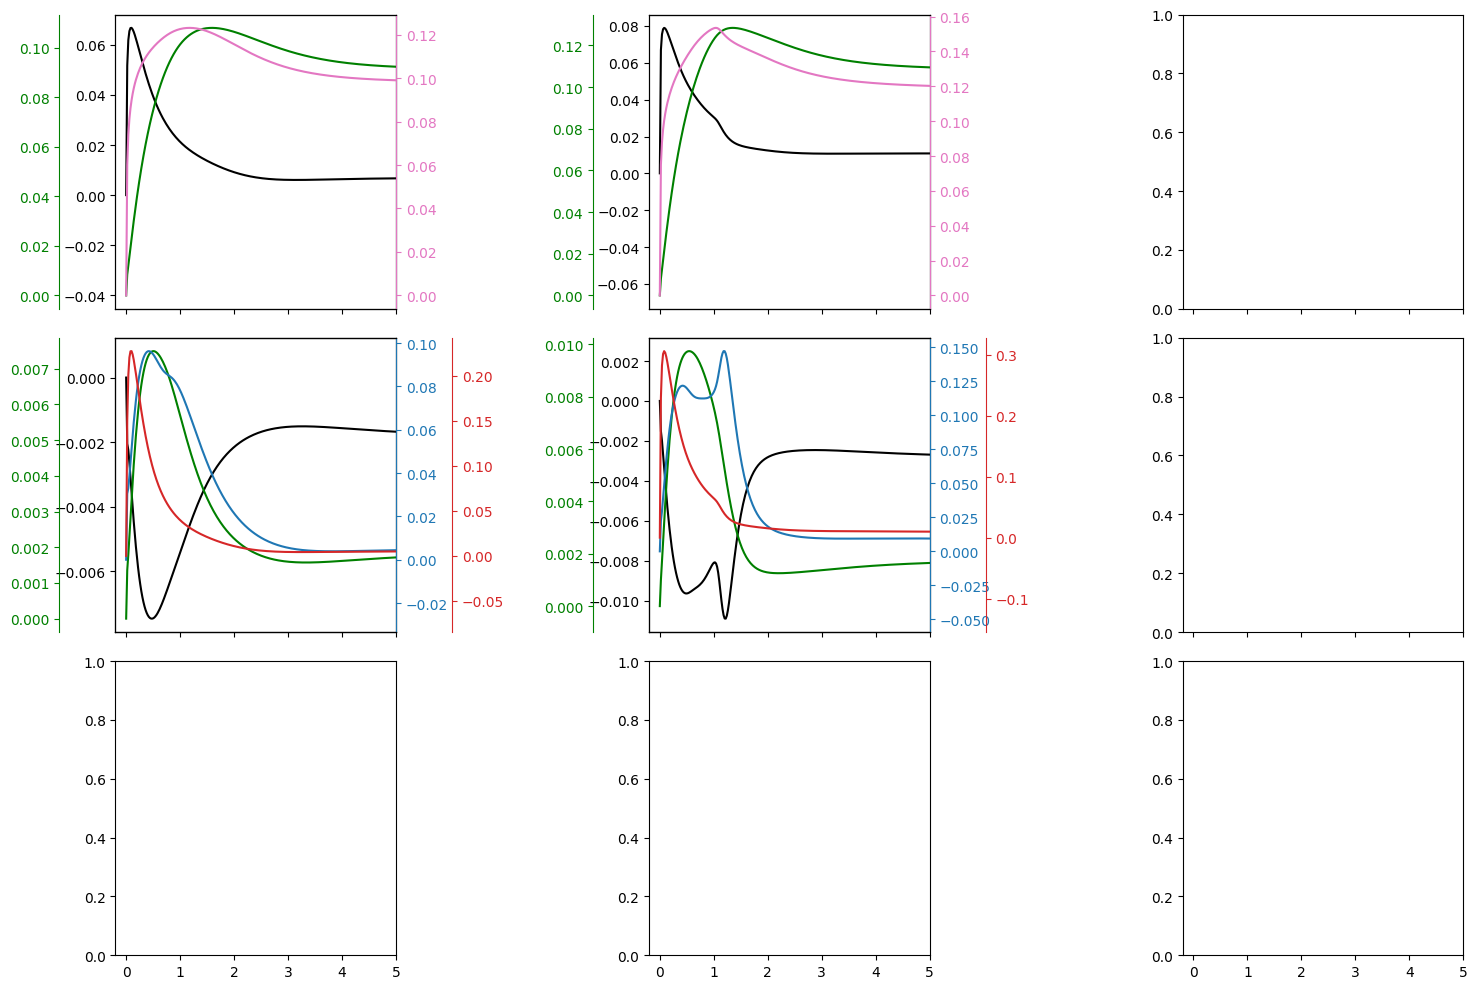

In [ ]:
res_fig4 = {}
for g_type in (pbar := tqdm(["WT", "clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"])):
    pbar.set_description(f"Simulating '{g_type}'")
    new_pars = change_params(params.copy(), g_type) if g_type != "WT" else params.copy()
    res_fig4[g_type] = {
        "100": lightsim_20min_5min(100, new_pars),
        "500": lightsim_20min_5min(500, new_pars)
    }


In [48]:
light_100 = make_protocol([(6 * 60, {"PAR": 100})])
light_500 = make_protocol([(6 * 60, {"PAR": 500})])

g_types = ["WT", "clce2", "vccn1", "kea3", "clce2vccn1", "clce2kea3", "vccn1kea3", "vccn1clce2kea3"]

res_mine = {}
for g_type in (pbar := tqdm(g_types)):
    pbar.set_description(f"Simulating '{g_type}' in mxlpy")
    m = get_li2021()
    
    if "clce2" in g_type:
        m.update_parameter("k_CLCE", 0)
    if "vccn1" in g_type:
        m.update_parameter("k_VCCN1", 0)
    if "kea3" in g_type:
        m.update_parameter("k_KEA", 0)
    
    res_mine[g_type] = {}
    
    for par, prtc in zip(["100", "500"], [light_100, light_500]):
        s = Simulator(m)
        s.clear_results()
        s.update_parameter("PAR", float(par))
        s.simulate(t_end=6*60, steps=10000)
        variables, fluxes = s.get_result()
        res_mine[g_type][par] = variables

Simulating 'vccn1clce2kea3' in mxlpy: 100%|██████████| 8/8 [00:18<00:00,  2.27s/it]


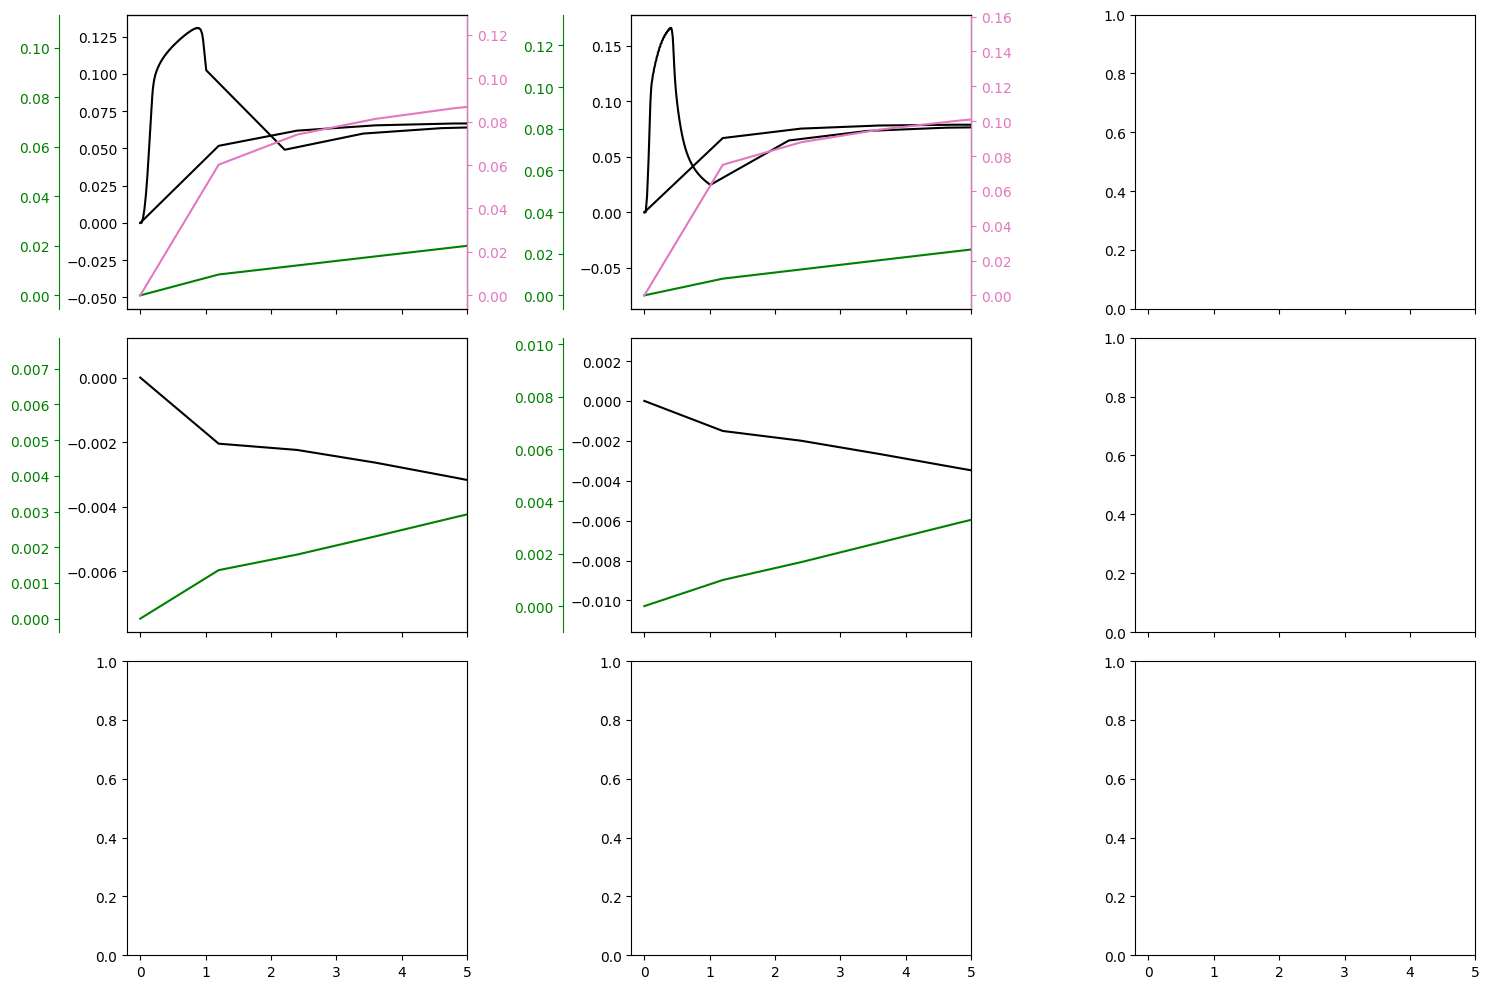

In [52]:

fig4, axs = plt.subplot_mosaic([
    ["A", "B", "C"],
    ["D", "E", "F"],
    ["G", "H", "I"]
], figsize=(15, 10), sharex=True)

for ax, par in zip(["A", "B"], ["100", "500"]):
    axs[ax].plot(res_mine["WT"][par].index, res_mine["WT"][par]["Dy"], color="black")
    axs[ax].plot(res_old["WT"][par]["time_axis"], res_old["WT"][par]["Dy"], color="black")
    
    ph_axis = axs[ax].twinx()
    ph_axis.spines["left"].set_position(("axes", -0.2))
    ph_axis.spines["left"].set_visible(True)
    ph_axis.spines["left"].set_color("green")
    ph_axis.yaxis.set_label_position('left')
    ph_axis.yaxis.set_ticks_position('left')
    ph_axis.tick_params(axis='y', colors='green')
    ph_axis.plot(res_mine["WT"][par].index, res_mine["WT"][par]["delta_pH_inVolts"], color="green")
    
    pmf_axis = axs[ax].twinx()
    pmf_axis.spines["right"].set_color("tab:pink")
    pmf_axis.tick_params(axis='y', colors='tab:pink')
    pmf_axis.plot(res_mine["WT"][par].index, res_mine["WT"][par]["pmf"], color="tab:pink")
    
for ax, par in zip(["D", "E"], ["100", "500"]):
    axs[ax].plot(res_mine["WT"][par].index, res_mine["WT"][par]["Dy"] - res_mine["vccn1"][par]["Dy"], color="black")
    
    ph_axis = axs[ax].twinx()
    ph_axis.spines["left"].set_position(("axes", -0.2))
    ph_axis.spines["left"].set_visible(True)
    ph_axis.spines["left"].set_color("green")
    ph_axis.yaxis.set_label_position('left')
    ph_axis.yaxis.set_ticks_position('left')
    ph_axis.tick_params(axis='y', colors='green')
    ph_axis.plot(res_mine["WT"][par].index, res_mine["WT"][par]["delta_pH_inVolts"] - res_mine["vccn1"][par]["delta_pH_inVolts"], color="green")
    
    # K_axis = axs[ax].twinx()
    # K_axis.spines["right"].set_color("tab:blue")
    # K_axis.tick_params(axis='y', colors='tab:blue')
    # K_axis.plot(res_mine["WT"][par].index, (res_mine["WT"][par]["v_KEA"] - res_mine["WT"][par]["v_K_channel"]) - (res_mine["vccn1"][par]["v_KEA"] - res_mine["vccn1"][par]["v_K_channel"]), color="tab:blue")
    
    # Cl_axis = axs[ax].twinx()
    # Cl_axis.spines["right"].set_position(("axes", 1.2))
    # Cl_axis.spines["right"].set_color("tab:red")
    # Cl_axis.tick_params(axis='y', colors='tab:red')
    # Cl_axis.plot(res_mine["WT"][par].index, (res_mine["WT"][par]["v_VCCN1"] + res_mine["WT"][par]["v_CLCE"]) - (res_mine["vccn1"][par]["v_VCCN1"] + res_mine["vccn1"][par]["v_CLCE"]), color="tab:red")

for ax in ["A", "B"]:
    axs[ax].set_xlim(-0.2, 5)

plt.tight_layout()

plt.show()

Simulating 'kea3': 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


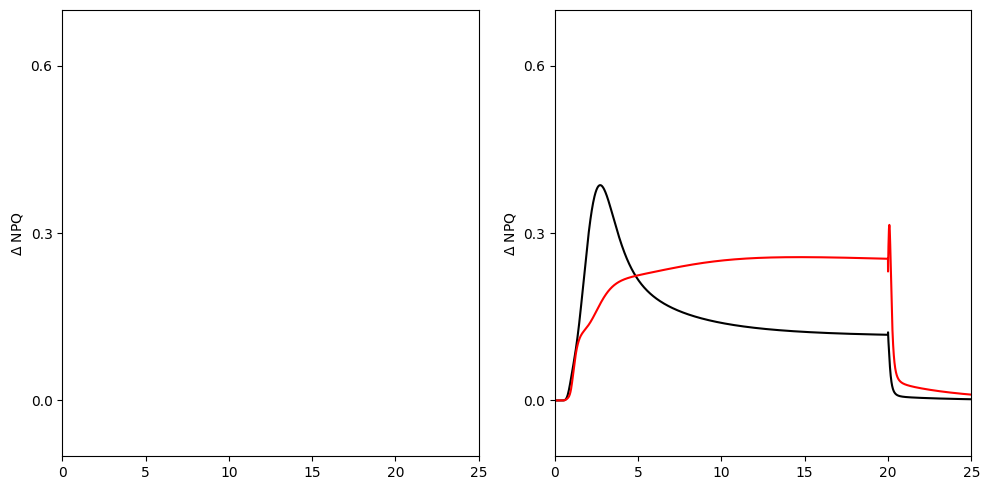

In [7]:
res_fig4_a = {}
for g_type in (pbar := tqdm(["WT", "kea3"])):
    pbar.set_description(f"Simulating '{g_type}'")
    new_pars = change_params(params.copy(), g_type) if g_type != "WT" else params.copy()
    res_fig4_a[g_type] = {
        "100": lightsim_20min_5min(100, new_pars),
        "500": lightsim_20min_5min(500, new_pars)
    }
    
fig4_a, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))


for par, color in zip(["100", "500"], ["black", "red"]):
    ax2.plot(res_fig4_a["kea3"][par]["time_min"], res_fig4_a["kea3"][par]["NPQ"] - res_fig4_a["WT"][par]["NPQ"], color = color)
    
for ax in (ax1, ax2):
    ax.set_ylim(-0.1, 0.7)
    ax.set_yticks([0, 0.3, 0.6])
    ax.set_ylabel(r"$\Delta$ NPQ")
    ax.set_xlim(0, 25)
    ax.set_xticks([0, 5, 10, 15, 20, 25])
    
plt.tight_layout()